In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
from py4DSTEM.file.io import FileBrowser

In [4]:
fp = "/home/ben/Data/20191218_Elastomer_JennDonohue_ellipticalDistortionsBVM/01_Elastomer_braggvectormap.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_shiftcorrected       DiffractionSlice    


In [5]:
bvm = browser.get_dataobject('braggvectormap_shiftcorrected').data
browser.close()

Q_Nx,Q_Ny = bvm.shape

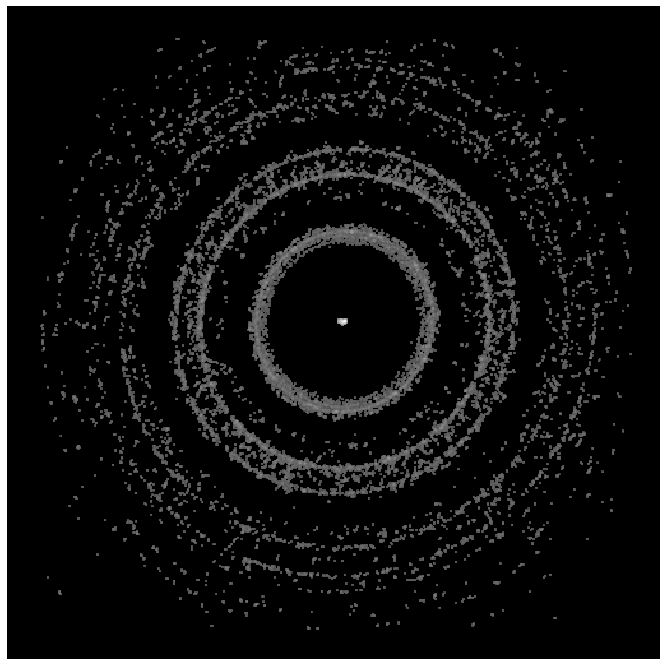

In [86]:
power = 0.07

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm**power)
ax.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/bvm.pdf")
plt.show()

### Fit an ellipse

In [87]:
from matplotlib.patches import Circle, Ellipse
from scipy.ndimage.filters import gaussian_filter
from py4DSTEM.process.utils import fit_ellipse_inside_annulus

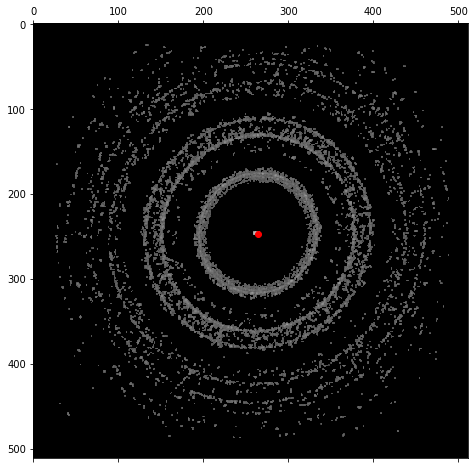

In [88]:
# Find center

power = 0.07

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(bvm,2)),(Q_Nx,Q_Ny))

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(bvm**power)
ax.scatter(y0,x0,color='r')
plt.show()

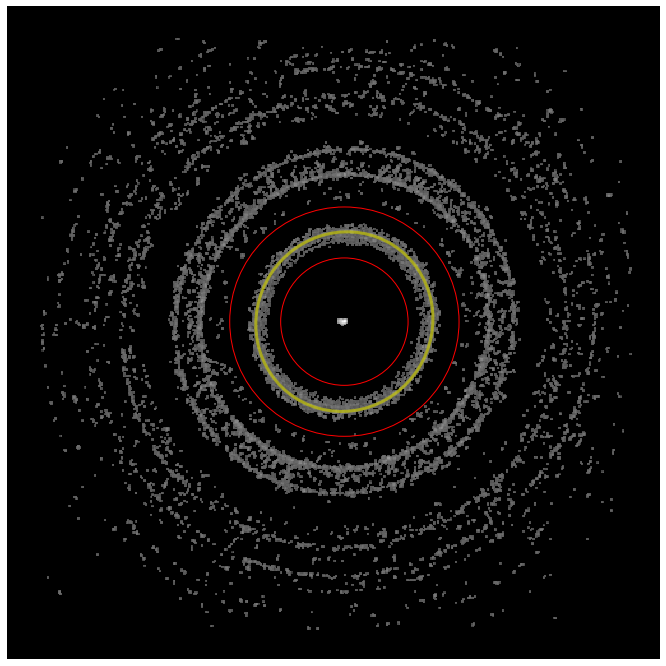

In [89]:
# Fit an ellipse

# r_inner = 100
# r_outer = 125
r_inner = 50
r_outer = 90

ellipse_params = fit_ellipse_inside_annulus(bvm, x0, y0, r_inner, r_outer)
x0_,y0_,A_,B_,phi_ = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(bvm**power)
circle_inner = Circle((y0_,x0_),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_,x0_),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_,x0_),2*A_,2*B_,90-np.degrees(phi_), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

In [90]:
print("{:.2f}% elliptical distortion".format(100*(1-B_/A_)))

3.35% elliptical distortion


### Polar Elliptical transform

In [91]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

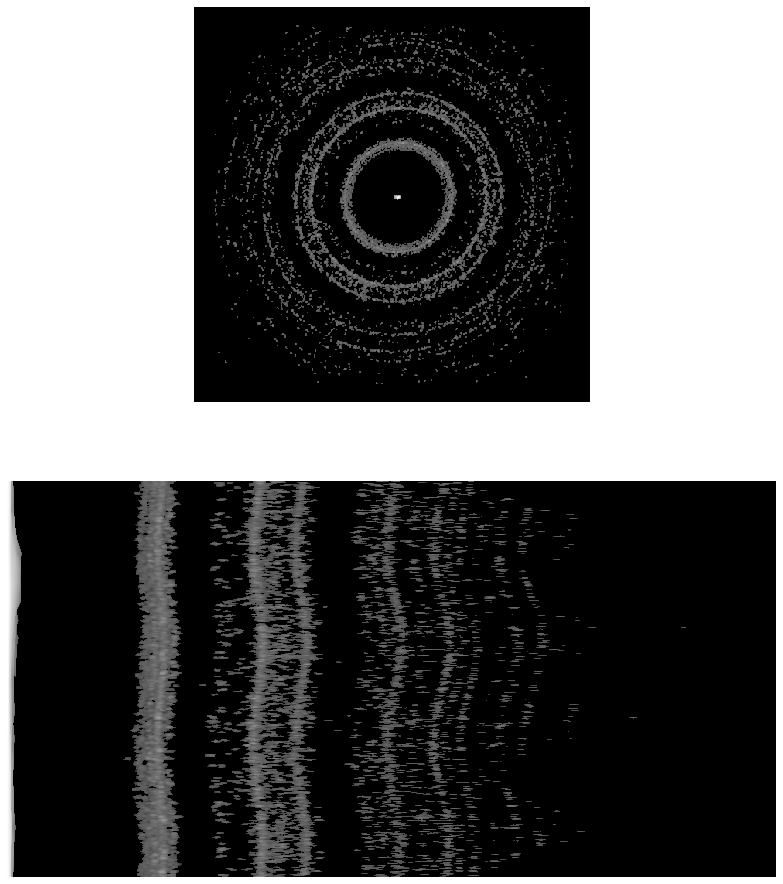

In [93]:
# Polar transform (i.e. A=B)
ellipse_params = (x0_,y0_,1,1,0)

polarData,rr_polar,tt_polar = cartesianDataAr_to_polarEllipticalDataAr(
                    cartesianData=bvm,
                    params=ellipse_params,
                    dr=.25,
                    r_range=350,
                    dtheta=np.radians(0.5),
                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.matshow(bvm**power)
ax2.matshow(polarData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/polartransform.pdf")
plt.show()

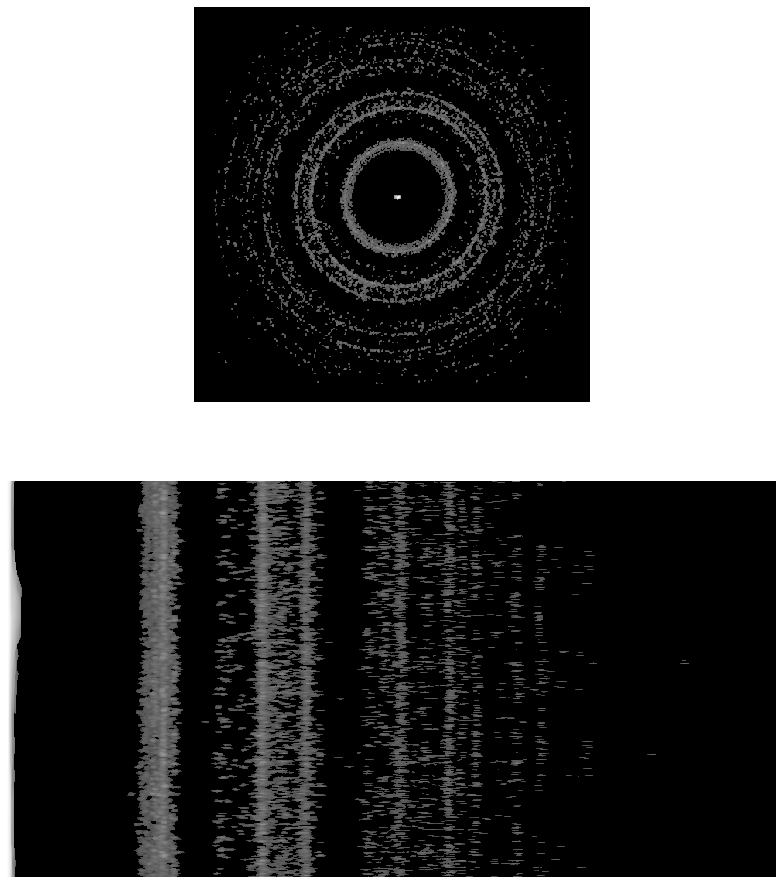

In [94]:
# Polar-elliptical transform

ellipse_params = (x0_,y0_,1,B_/A_,phi_)

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=bvm,
                                    params=ellipse_params,
                                    dr=.25,
                                    r_range=350,
                                    dtheta=np.radians(0.5),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.matshow(bvm**power)
ax2.matshow(polarEllipticalData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/polarellipticaltransform.pdf")
plt.show()

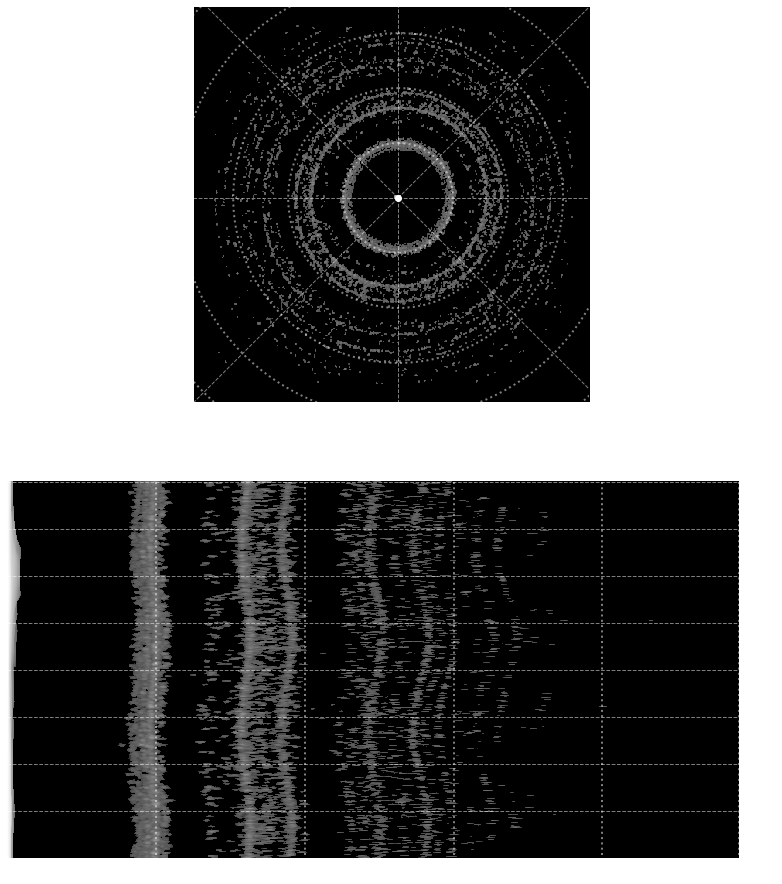

In [95]:
# Polar transform, with coordinate lines

color_axes = 'w'
alpha_axes = 0.5

r_vals = np.linspace(0,5,6)
circles = []
for i,r_val in enumerate(r_vals):
    circle = Circle((y0_,x0_),r_val*A_, fill=False,ec=color_axes,ls=":",lw=2, alpha=alpha_axes)
    circles.append(circle)

def get_xfyf(x0,y0,theta):
    R = 600
    xf = x0 + A_*R*np.cos(theta)
    yf = y0 + A_*R*np.sin(theta)
    return xf,yf

Nt,Nr = polarData.data.shape

rs = rr_polar[0,:]
vlines = np.argmin((np.tile(A_*r_vals,(len(rs),1)) - np.tile(rs,(len(r_vals),1)).T)**2, axis=0)
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.scatter(y0_,x0_,color=color_axes)
for circle in circles:
    ax1.add_patch(circle)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta)
    ax1.plot((y0_,yf),(x0_,xf),color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax1.matshow(bvm**power)
ax1.axis('off')

ax2.matshow(polarData.data**power)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax2.vlines(vlines,0,Nt,color=color_axes,ls=":",lw=2, alpha=alpha_axes)
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/polartransform_coordaxes.pdf")
plt.show()

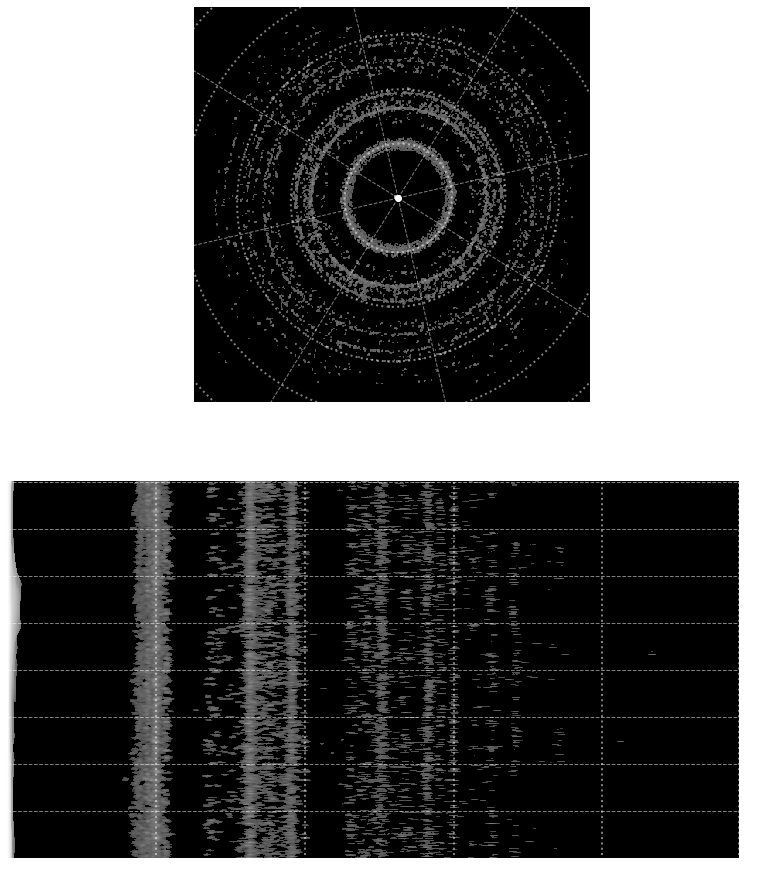

In [96]:
# Polar-elliptical transform, with coordinate lines

color_axes = 'w'
alpha_axes = 0.5

r_vals = np.linspace(0,5,6)
ellipses = []
for i,r_val in enumerate(r_vals):
    ellipse = Ellipse((y0_,x0_),r_val*2*A_,r_val*2*B_,90-np.degrees(phi_), fill=False,ec=color_axes,ls=":",lw=2, alpha=alpha_axes)
    ellipses.append(ellipse)

def get_xfyf(x0,y0,theta,phi):
    R = 600
    xf = x0 + A_*R*np.cos(theta)*np.cos(phi) - B_*R*np.sin(theta)*np.sin(phi)
    yf = y0 + B_*R*np.cos(theta)*np.sin(phi) + A_*R*np.sin(theta)*np.cos(phi)
    return xf,yf

Nt,Nr = polarEllipticalData.data.shape

rs = rr[0,:]
vlines = np.argmin((np.tile(A_*r_vals,(len(rs),1)) - np.tile(rs,(len(r_vals),1)).T)**2, axis=0)
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.scatter(y0_,x0_,color=color_axes)
for ellipse in ellipses:
    ax1.add_patch(ellipse)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta,phi_)
    ax1.plot((y0_,yf),(x0_,xf),color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax1.matshow(bvm**power)
ax1.axis('off')

ax2.matshow(polarEllipticalData.data**power)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax2.vlines(vlines,0,Nt,color=color_axes,ls=":",lw=2, alpha=alpha_axes)
ax2.axis('off')
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/polarellipticaltransform_coordaxes.pdf")
plt.show()

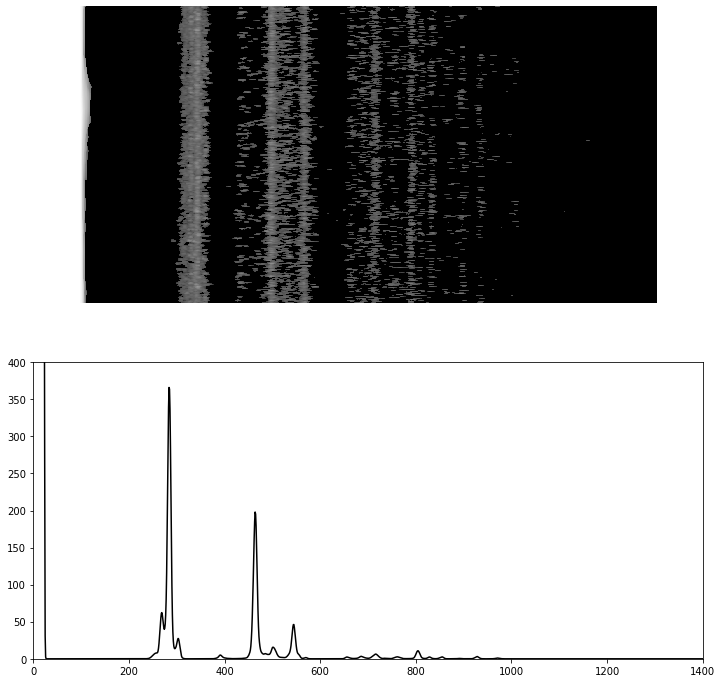

In [101]:
# radial integral

sigma=0

radial_integral = np.mean(polarEllipticalData,axis=0)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(polarEllipticalData.data**power)
ax2.plot(np.arange(len(radial_integral)),gaussian_filter(radial_integral,sigma),color='k')
ax1.axis('off')
ax2.set_xlim(0,polarEllipticalData.shape[1])
ax2.set_ylim(0,400)
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/radial_integral.pdf")
plt.show()

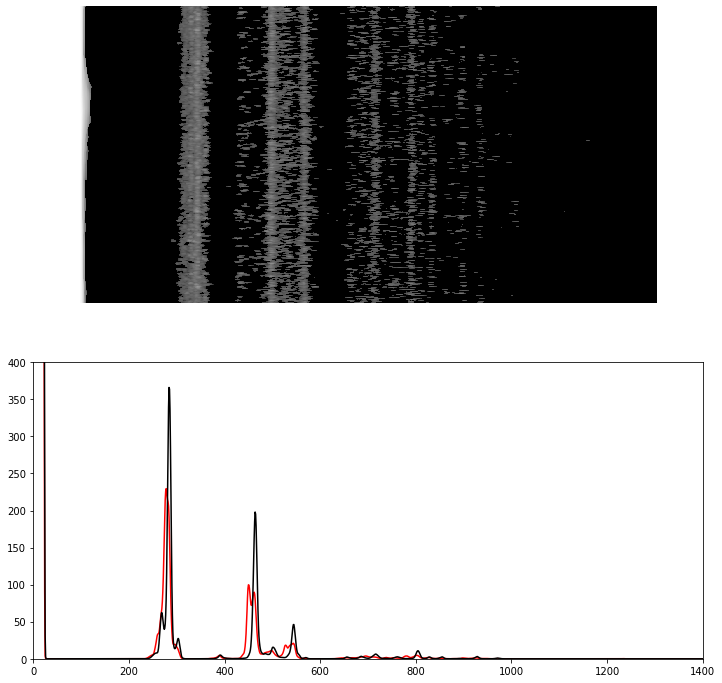

In [100]:
# radial integral

sigma=0

radial_integral = np.mean(polarEllipticalData,axis=0)
radial_integral_polar = np.mean(polarData,axis=0)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(polarEllipticalData.data**power)
ax2.plot(np.arange(len(radial_integral_polar)),gaussian_filter(radial_integral_polar,sigma),color='r')
ax2.plot(np.arange(len(radial_integral)),gaussian_filter(radial_integral,sigma),color='k')
ax1.axis('off')
ax2.set_xlim(0,polarEllipticalData.shape[1])
ax2.set_ylim(0,400)
plt.savefig("/home/ben/Projects/py4DSTEM/PaperFigures/polartransform/radial_integral_both.pdf")
plt.show()